## Bài toán 2: Đề xuất người dùng với Collaborative filtering

### Bước 1: Business Understanding

Vấn đề hiện tại: Chưa có hệ thống Recommendation System để hỗ trợ người dùng chọn nơi lưu trú phù hợp trên Agoda.

Mục tiêu: Xây dựng hệ thống đề xuất để hỗ trợ người dùng nhanh chóng chọn được nơi lưu trú phù hợp trên Agoda.

・Collaborative filtering: Mô hình này sẽ dựa trên thông tin từ những người dùng khác có hành vi tương tự để đề xuất nơi lưu trú. Nếu nhiều người dùng có cùng sở thích hoặc đánh giá tương tự về các địa điểm, mô hình sẽ sử dụng thông tin này để gợi ý những lựa chọn phù hợp.

### Bước 2: Data Understanding-Tiền xử lý dữ liệu

Thiet lap moi truong khi su dung colab

In [1]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
# !tar xf spark-3.1.2-bin-hadoop2.7.tgz
# !pip install -q findspark

Mounted at /content/gdrive


In [2]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [4]:
sc =SparkContext()

In [5]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# %cd '/content/gdrive/MyDrive/PJ2'

[WinError 3] The system cannot find the path specified: "'/content/gdrive/MyDrive/PJ2'"
c:\Users\81707\Desktop\DATA SCIENCE MACHINE LEARNING\⑦Đồ Án\Triển khai project 2 Recommender System


c:\Users\81707\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [5]:
spark = SparkSession(sc)

In [6]:
spark

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
hotel_comments= pd.read_csv("hotel_comments.csv")

In [9]:
hotel_comments.head(3)

,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


In [10]:
hotel_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB


Cột num  và review id không có giá trị trùng ->xóa

In [11]:
hotel_comments=hotel_comments.drop(columns=['num','Reviewer ID'])

In [12]:
hotel_comments.isna().sum()

Hotel ID          0
Reviewer Name    86
Nationality       0
Group Name        0
Room Type         0
Stay Details      0
Score             0
Score Level       0
Title             0
Body             42
Review Date       0
dtype: int64

Dữ liệu Nan

Review Name:86

Body:42

In [13]:
hotel_comments.dropna(subset=['Reviewer Name'], inplace=True)

In [14]:
hotel_comments.duplicated(subset= ['Reviewer Name']).sum()

72038

Khi kiểm tra file CSV, nhận thấy hai trường hợp như sau:

Không có dữ liệu trùng lặp ở cột review_id: Điều này cho thấy mỗi dòng trong dữ liệu đều có một mã duy nhất.

Trùng lặp ở cột reviewer_name:

・Cùng một reviewer_name đánh giá trùng lặp nội dung cho cùng một hotel_id nhiều lần: Trong trường hợp này, sẽ lọc bỏ các dòng trùng lặp và chỉ giữ lại dòng cuối cùng.

・Cùng một reviewer_name đánh giá cho các hotel_id khác nhau: Đây có thể là tình huống một người đánh giá nhiều khách sạn khác nhau hoặc có thể là hai người khác nhau tình cờ trùng tên.

Trường hợp 1: Cùng một reviewer_name đánh giá nội dung trùng lặp cho cùng một hotel_id nhiều lần với tất cả các cột đều giống nhau. Trong trường hợp này,  sẽ lọc bỏ các dòng trùng lặp và chỉ giữ lại dòng cuối cùng.


In [15]:
columns_to_check = ['Hotel ID','Reviewer Name', 'Nationality', 'Group Name', 'Room Type', 'Stay Details', 'Score', 'Score Level', 'Title', 'Body']

In [ ]:
# # Tìm các dòng trùng lặp TH1
# duplicates = hotel_comments[hotel_comments.duplicated(subset=columns_to_check, keep=False)]
# # In các dòng trùng lặp
# duplicates.head()

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,1_1,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,1_1,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024
3,1_1,Nghĩa,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 3 đêm vào Tháng 6 năm 2024,"8,8",Tuyệt vời,Du lịch Nha Trang tại Mường Thanh”,Hôm đi đến lúc về thì mọi thứ trong Khách sạn ...,Đã nhận xét vào 02 tháng 7 2024
4,1_1,Duc,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Ks tốt !”,Khách sạn có vị trí trung tâm và sát biển. Nhâ...,Đã nhận xét vào 16 tháng 6 2024


In [16]:
num_duplicates_1 = hotel_comments.duplicated(subset=columns_to_check, keep=False).sum()
num_duplicates_1

66345

In [17]:
# Loại bỏ các dòng trùng lặp, giữ lại dòng cuối cùng trong mỗi nhóm trùng lặp
hotel_comments_clean = hotel_comments.drop_duplicates(subset=columns_to_check, keep='last')

In [18]:
hotel_comments_clean.shape

(31043, 11)

Sau khi lọc trùng lần 1 còn lại 31043 dòng

Trường hợp 2: Cùng một Reviewer Name đã đánh giá cho các Hotel ID khác nhau, nhưng nội dung đánh giá ở tất cả các cột là hoàn toàn giống nhau. 
 Giả sử không thể nào 1 người có  3 thông số review name,nationality,groupname  giống nhau lại có thể reviewdate giống nhau
 -? tạo review id mới

In [19]:
from pyspark.sql import Window
from pyspark.sql.functions import col, dense_rank

In [23]:
hotel_comments_clean.columns

Index(['Hotel ID', 'Reviewer Name', 'Nationality', 'Group Name', 'Room Type',
       'Stay Details', 'Score', 'Score Level', 'Title', 'Body', 'Review Date'],
      dtype='object')

In [29]:
df_unique = hotel_comments_clean.copy()

In [30]:
# Loại bỏ dữ liệu có cùng'Hotel ID', 'Reviewer_Name', 'Nationality', 'Group_Name' và ngày đánh giá giống nhau
df_unique = df_unique.drop_duplicates(subset=['Hotel ID', 'Reviewer Name', 'Nationality', 'Group Name', 'Review Date', 'Score'])

In [31]:
df_unique.shape

(30410, 11)

In [32]:
df_unique['Review ID'] = df_unique.groupby(['Reviewer Name', 'Nationality', 'Group Name']).ngroup() + 1

In [34]:
df_unique.head()

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date,Review ID
1033,1_1,LÊ,Việt Nam,Gia đình có em bé,Phòng Gia Đình Loại Sang,Đã ở 4 đêm vào Tháng 2 năm 2024,"8,8",Tuyệt vời,Bữa Sáng”,Bữa Sáng,Đã nhận xét vào 21 tháng 2 2024,5522
1034,1_1,Nguyen,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,Ok,Đã nhận xét vào 21 tháng 2 2024,6579
1035,1_1,Dũng,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tuyệt vời”,Tuyệt vời,Đã nhận xét vào 20 tháng 2 2024,1994
1036,1_1,Nguyên,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tốt”,Tốt,Đã nhận xét vào 20 tháng 2 2024,6591
1037,1_1,Thai,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 2 đêm vào Tháng 2 năm 2024,"8,0",Tuyệt vời,Good”,Recomend,Đã nhận xét vào 19 tháng 2 2024,8982


In [37]:
review_id_counts = df_unique.groupby('Review ID').size().reset_index(name='count')

# Sắp xếp theo số lượng giảm dần
review_id_counts_sorted = review_id_counts.sort_values(by='count', ascending=False)
print(review_id_counts_sorted.head(20))  

      Review ID  count
6601       6602    230
6578       6579    152
6580       6581    144
6603       6604    141
6095       6096    120
8999       9000    119
9047       9048    108
9045       9046     90
5533       5534     89
9575       9576     80
9001       9002     76
6605       6606     73
379         380     73
6582       6583     71
6097       6098     70
5355       5356     62
9049       9050     58
9459       9460     56
6604       6605     55
9614       9615     52


In [43]:
df_unique.head()

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date,Review ID
1033,1_1,LÊ,Việt Nam,Gia đình có em bé,Phòng Gia Đình Loại Sang,Đã ở 4 đêm vào Tháng 2 năm 2024,"8,8",Tuyệt vời,Bữa Sáng”,Bữa Sáng,Đã nhận xét vào 21 tháng 2 2024,5522
1034,1_1,Nguyen,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,Ok,Đã nhận xét vào 21 tháng 2 2024,6579
1035,1_1,Dũng,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tuyệt vời”,Tuyệt vời,Đã nhận xét vào 20 tháng 2 2024,1994
1036,1_1,Nguyên,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tốt”,Tốt,Đã nhận xét vào 20 tháng 2 2024,6591
1037,1_1,Thai,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 2 đêm vào Tháng 2 năm 2024,"8,0",Tuyệt vời,Good”,Recomend,Đã nhận xét vào 19 tháng 2 2024,8982


In [44]:
hotel_comments_clean=df_unique

In [45]:
hotel_comments_clean.head()

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date,Review ID
1033,1_1,LÊ,Việt Nam,Gia đình có em bé,Phòng Gia Đình Loại Sang,Đã ở 4 đêm vào Tháng 2 năm 2024,"8,8",Tuyệt vời,Bữa Sáng”,Bữa Sáng,Đã nhận xét vào 21 tháng 2 2024,5522
1034,1_1,Nguyen,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,Ok,Đã nhận xét vào 21 tháng 2 2024,6579
1035,1_1,Dũng,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tuyệt vời”,Tuyệt vời,Đã nhận xét vào 20 tháng 2 2024,1994
1036,1_1,Nguyên,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 2 năm 2024,"10,0",Trên cả tuyệt vời,Tốt”,Tốt,Đã nhận xét vào 20 tháng 2 2024,6591
1037,1_1,Thai,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 2 đêm vào Tháng 2 năm 2024,"8,0",Tuyệt vời,Good”,Recomend,Đã nhận xét vào 19 tháng 2 2024,8982


In [47]:
group_reviewer_id= hotel_comments_clean[hotel_comments_clean['Review ID'] == 9615]
group_reviewer_id

,Hotel ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date,Review ID
2509,1_4,Tuan,Việt Nam,Cặp đôi,Phòng Loại Sang,Đã ở 2 đêm vào Tháng 4 năm 2024,"8,8",Tuyệt vời,Tuyệt vời”,The swimming pool is closed at 17:00 which is ...,Đã nhận xét vào 15 tháng 4 2024,9615
3527,1_6,Tuan,Việt Nam,Cặp đôi,Studio hướng biển có ban công,Đã ở 1 đêm vào Tháng 6 năm 2023,"7,2",Rất tốt,Đáng ở”,Chỗ ở khá ok!,Đã nhận xét vào 29 tháng 7 2023,9615
6478,1_16,Tuan,Việt Nam,Cặp đôi,Deluxe giường đôi Hướng phố,Đã ở 1 đêm vào Tháng 8 năm 2022,"9,2",Trên cả tuyệt vời,Kì nghỉ trọn vẹn”,Khách sạn nằm trong 'khu phố Tây' ở Nha Trang ...,Đã nhận xét vào 29 tháng 8 2022,9615
7155,1_19,Tuan,Việt Nam,Cặp đôi,Deluxe Hướng phố Có ban công,Đã ở 1 đêm vào Tháng 11 năm 2022,"7,2",Rất tốt,Rất tốt”,"Phòng sạch sẽ đáp ứng nhu cầu lưu trú cơ bản, ...",Đã nhận xét vào 21 tháng 11 2022,9615
7780,1_21,Tuan,Việt Nam,Cặp đôi,Phòng Deluxe hướng biển,Đã ở 2 đêm vào Tháng 7 năm 2024,"9,6",Trên cả tuyệt vời,Rất tốt”,Mọi thứ đều tuyệt vời. Ngoại trừ quầy bánh ở L...,Đã nhận xét vào 15 tháng 7 2024,9615
8903,1_23,Tuan,Việt Nam,Cặp đôi,Phòng Đôi Loại Sang Tầng Cao,Đã ở 3 đêm vào Tháng 6 năm 2024,"10,0",Trên cả tuyệt vời,Trên cả tuyệt vời”,"Tuyệt , giá hợp lý",Đã nhận xét vào 10 tháng 6 2024,9615
10465,1_26,Tuan,Việt Nam,Cặp đôi,Phòng Deluxe giường đôi có cửa sổ,Đã ở 1 đêm vào Tháng 3 năm 2024,"10,0",Trên cả tuyệt vời,Sạch ấp giá tốt ”,Phòng đẹp giá tốt,Đã nhận xét vào 13 tháng 3 2024,9615
17491,2_14,Tuan,Việt Nam,Cặp đôi,Phòng Superior Giường đôi/2 Giường đơn,Đã ở 1 đêm vào Tháng 1 năm 2024,"8,4",Tuyệt vời,Kỳ nghỉ thoải mái”,Tôi đã có thời gian lưu trú thoải mái ở khách ...,Đã nhận xét vào 25 tháng 1 2024,9615
17622,2_14,Tuan,Việt Nam,Cặp đôi,Phòng Superior Giường đôi/2 Giường đơn,Đã ở 1 đêm vào Tháng 4 năm 2024,"8,4",Tuyệt vời,Tuyệt vời”,"Mùa du lịch với giá này là hợp lý, thậm chí rấ...",Đã nhận xét vào 12 tháng 4 2024,9615
18891,2_15,Tuan,Việt Nam,Cặp đôi,Phòng Hảo Hạng,Đã ở 2 đêm vào Tháng 3 năm 2023,"9,6",Trên cả tuyệt vời,Trên cả tuyệt vời”,Cảnh quan xanh mát phù hợp nghỉ dưỡng,Đã nhận xét vào 25 tháng 3 2023,9615


In [48]:
hotel_comments_clean.columns

Index(['Hotel ID', 'Reviewer Name', 'Nationality', 'Group Name', 'Room Type',
       'Stay Details', 'Score', 'Score Level', 'Title', 'Body', 'Review Date',
       'Review ID'],
      dtype='object')

In [49]:
# Tính số lượng các giá trị duy nhất trong cột 'Reviewer ID'
num_unique_reviewer_ids = hotel_comments_clean['Review ID'].nunique()
num_total_reviewer_ids = hotel_comments_clean['Review ID'].count()
num_duplicate_reviewer_ids = num_total_reviewer_ids - num_unique_reviewer_ids
print(f"Số lượng 'Reviewer ID' duy nhất: {num_unique_reviewer_ids}")
print(f"Số lượng 'Reviewer ID' trùng lặp: {num_duplicate_reviewer_ids}")

Số lượng 'Reviewer ID' duy nhất: 13792
Số lượng 'Reviewer ID' trùng lặp: 16618


In [ ]:
# # Xóa các dòng trùng lặp dựa trên Reviewer Name và tất cả các cột nội dung
# hotel_comments_clean = hotel_comments_clean.drop_duplicates(subset=columns_to_check_1, keep='last')

In [52]:
hotel_comments_clean.shape

(30410, 12)

In [54]:
# Đếm số lần xuất hiện của mỗi Reviewer ID
reviewer_id_counts = hotel_comments_clean['Review ID'].value_counts()
duplicate_reviewers_id= reviewer_id_counts[reviewer_id_counts > 1]
print(duplicate_reviewers_id)

Review ID
6602     230
6579     152
6581     144
6604     141
6096     120
        ... 
12817      2
4939       2
10424      2
12225      2
5036       2
Name: count, Length: 4454, dtype: int64


In [56]:
# Đếm số lần xuất hiện của mỗi Reviewer Name
reviewer_name_counts = hotel_comments_clean['Reviewer Name'].value_counts()

In [57]:
# Lọc ra những Reviewer Name xuất hiện nhiều hơn 1 lần
duplicate_reviewers = reviewer_name_counts[reviewer_name_counts > 1]
print(duplicate_reviewers)

Reviewer Name
Nguyễn       570
Nguyen       488
Thi          355
Thanh        302
Minh         301
            ... 
Yein           2
Jisun          2
Tingping       2
GAYEON         2
Sappachai      2
Name: count, Length: 3408, dtype: int64


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# Lấy top 20 tên phổ biến nhất
top_names = reviewer_name_counts.head(20)

C:\Users\81707\AppData\Local\Temp\ipykernel_6980\3996202572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_names.values, y=top_names.index, palette="viridis")


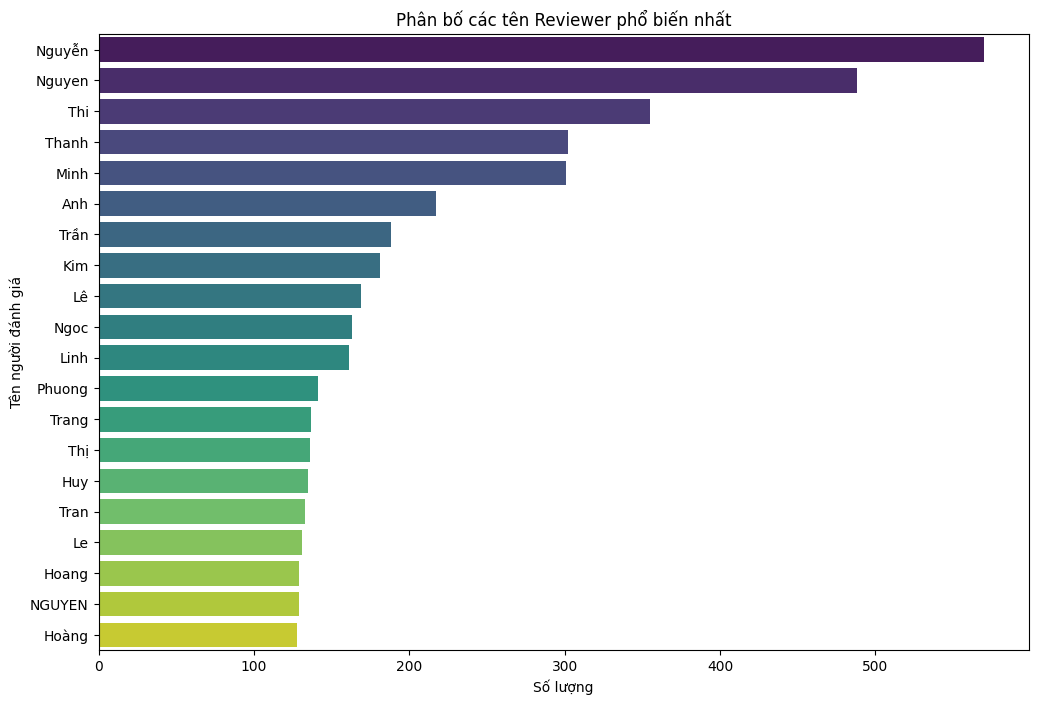

In [61]:
# Tạo biểu đồ cột
plt.figure(figsize=(12, 8))
sns.barplot(x=top_names.values, y=top_names.index, palette="viridis")
plt.xlabel('Số lượng')
plt.ylabel('Tên người đánh giá')
plt.title('Phân bố các tên Reviewer phổ biến nhất')
plt.show()

 Khi xem xét file CSV, nhận thấy rằng dữ liệu trong cột reviewer_name rất lộn xộn. Do đó,  chuyển tất cả tên người đánh giá thành chữ thường để đồng nhất. Sau đó,  sẽ kiểm tra lại các trùng lặp để làm sạch dữ liệu, giúp cho dữ liệu trở nên tinh gọn và chính xác hơn.->Hien tai dang tim hieu cach lam

Chuyển giá trị cột Score từ string->float

In [62]:
# Xem tất cả các giá trị duy nhất trong cột 'Score'
unique_scores = hotel_comments_clean['Score'].unique()
print(unique_scores)

['8,8' '10,0' '8,0' '9,2' '9,6' '8,4' '7,6' '6,4' '7,2' '6,8' '8,7' '7,7'
 '9,5' '9,7' '6,7' '6,3' '9,0' '7,5' '8,3' '9,3' '7,3' '7,0']


In [63]:
# Thay thế dấu phẩy bằng dấu chấm
hotel_comments_clean['Score'] = hotel_comments_clean['Score'].astype(str).str.replace(',', '.')
# Chuyển đổi cột sang kiểu float
hotel_comments_clean['Score'] = pd.to_numeric(hotel_comments_clean['Score'], errors='coerce')

In [64]:
hotel_comments_clean['Score'].dtype

dtype('float64')

In [65]:
# Lọc những hàng có giá trị NaN ở cả 'Reviewer Name' và 'Score'
nan_count = hotel_comments_clean[hotel_comments_clean[['Reviewer Name', 'Score']].isna().all(axis=1)].shape[0]

In [66]:
nan_count

0

Sử dung package của  trung tâm

In [67]:
from analysis.analyzer import TTTH_Analyzer as Analyzer

In [68]:
_analyzer = Analyzer()

=====
central tendency of Score: {'mean': 9.227333114107202, 'median': 9.6, 'mode': 10.0, 'min': 6.3, 'max': 10.0, 'range': 3.7}
=====
Dispersion of Score: 
 {'range': 3.7, 'q1': 8.8, 'q3': 10.0, 'iqr': 1.1999999999999993, 'var': 0.9816732123895587, 'skew': -1.21370388097354, 'kurtosis': 0.4539172180334776}
=====


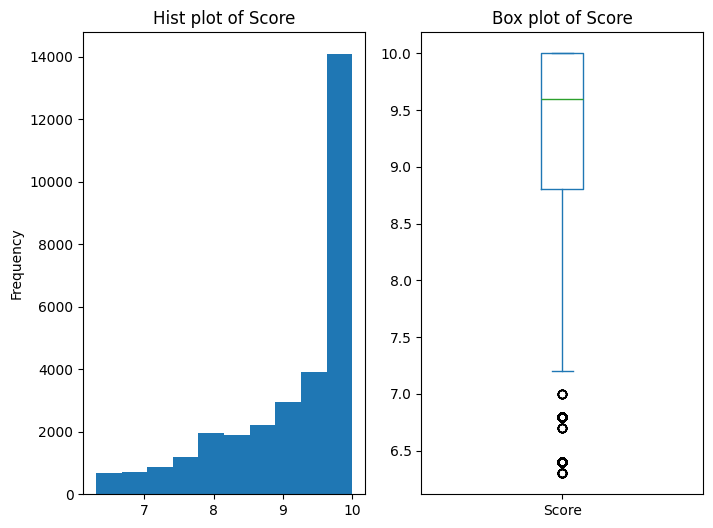

In [69]:
# Biến numeric: Score
_analyzer.analyze_numeric_variable(variable_name='Score', df=hotel_comments_clean)

Skewness = -1.23:
Giá trị âm của độ lệch cho thấy phân phối của Score bị lệch về phía trái,có nhiều điểm số cao hơn. Các điểm số thấp hơn (ví dụ: 6, 7) ít xuất hiện và thường nằm ở đuôi bên trái.
Sự lệch trái cho thấy rằng hầu hết khách hàng có xu hướng cho điểm cao, nhưng có một số ít khách hàng cho điểm thấp kéo phần đuôi của phân phối về phía trái.
Score 10 chiem so luong kha nhieu

In [70]:
_analyzer.check_imbalance_class(variable_name='Score', df=hotel_comments_clean)

Class count of Score:

Score
10.0    0.462085
9.6     0.127458
9.2     0.095922
8.8     0.072114
8.0     0.064189
8.4     0.061361
7.6     0.037915
7.2     0.027918
6.8     0.023085
6.4     0.021309
8.3     0.001052
7.7     0.000921
9.0     0.000756
8.7     0.000756
6.3     0.000691
9.7     0.000658
9.3     0.000658
7.3     0.000427
6.7     0.000329
7.0     0.000296
9.5     0.000066
7.5     0.000033
Name: proportion, dtype: float64
Ratio of 2 class is 14052.0
You should consider to handle imbalance


In [71]:
# Lấy tất cả các giá trị duy nhất trong cột 'room type'
unique_room_types = hotel_comments_clean['Room Type'].unique()
unique_room_types

array(['Phòng Gia Đình Loại Sang', 'Deluxe giường đôi Hướng phố',
       'Deluxe 2 giường Hướng phố', ..., 'Bungalow Deluxe',
       'Phòng Giường Đôi Có Ban Công', 'Phòng 4 người có ban công'],
      dtype=object)

In [72]:
# Lấy tất cả các giá trị duy nhất trong cột 'Nationality	'
unique_Nationality = hotel_comments_clean['Nationality'].unique()
unique_Nationality

array(['Việt Nam', 'Hoa Kỳ', 'Nhật Bản', 'Trung Quốc', 'Bắc Macedonia',
       'Hàn Quốc', 'Canada', 'Singapore', 'Malaysia', 'Thụy Điển',
       'Vương quốc Anh', 'Campuchia', 'Thái Lan', 'Úc', 'Ấn Độ',
       'Bangladesh', 'Nga', 'Pháp', 'Kazakhstan', 'Philippines',
       'New Zealand', 'Indonesia', 'Hồng Kông', 'Nepal', 'Latvia',
       'Tây Ban Nha', 'Monaco', 'Thổ Nhĩ Kỳ', 'Israel', 'Đức', 'Ukraine',
       'Pakistan', 'Ai Cập', 'Áo', 'Tanzania', 'Ireland', 'Mông Cổ',
       'Ả Rập Xê Út', 'Armenia', 'Guernsey', 'Ba Lan', 'Na Uy',
       'Đan Mạch', 'Uzbekistan', 'Cộng hòa Séc', 'Rumani', 'Đài Loan',
       'Bulgaria', 'Hy Lạp', 'Turkmenistan', 'Aruba', 'Hà Lan', 'Thụy Sĩ',
       'Argentina', 'Peru', 'Nam Phi', 'Bồ Đào Nha', 'Phần Lan',
       'Đảo Giáng Sinh', 'Belarus', 'Antigua & Barbuda', 'Lào',
       'Sri Lanka', 'Nigeria', 'Mexico',
       'Các Tiểu Vương Quốc Ả Rập Thống nhất', 'Lithuania', 'Bỉ',
       'Slovenia', 'Anguilla', 'Ý', 'Morocco (Ma Rốc)', 'Ma Cao',
       'B

In [73]:
# Đếm số lần xuất hiện của mỗi quốc tịch
nationality_counts = hotel_comments_clean['Nationality'].value_counts()

# Lấy top 10 quốc gia
top_10_nationalities = nationality_counts.head(10)
print(top_10_nationalities)


Nationality
Việt Nam          16991
Hàn Quốc           6093
Hoa Kỳ              924
Malaysia            697
Úc                  687
Trung Quốc          626
Hồng Kông           562
Thái Lan            469
Vương quốc Anh      405
Canada              366
Name: count, dtype: int64


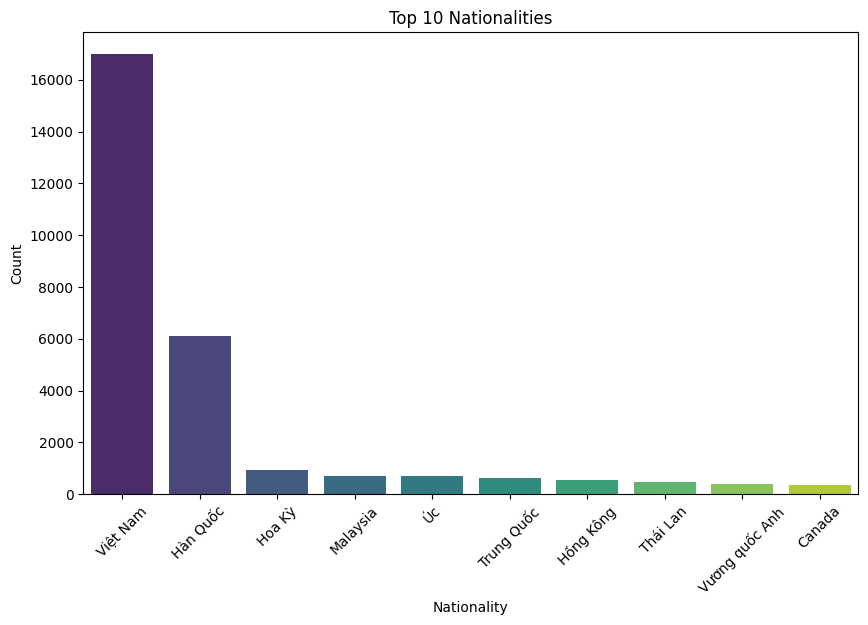

In [74]:
# Vẽ biểu đồ dạng thanh cho top 10 quốc gia
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_nationalities.index, y=top_10_nationalities.values, palette='viridis')
plt.title('Top 10 Nationalities')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [75]:
data_hotel_rw= hotel_comments_clean[['Hotel ID', 'Review ID', 'Score']]

In [76]:
data_hotel_rw

,Hotel ID,Review ID,Score
1033,1_1,5522,8.8
1034,1_1,6579,10.0
1035,1_1,1994,10.0
1036,1_1,6591,10.0
1037,1_1,8982,8.0
...,...,...,...
80309,43_29,3216,8.8
80310,43_29,3495,9.6
80311,43_29,9164,8.4
80312,43_29,12193,7.6


In [77]:
data_hotel_rw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30410 entries, 1033 to 80313
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hotel ID   30410 non-null  object 
 1   Review ID  30410 non-null  int64  
 2   Score      30410 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 950.3+ KB


In [78]:
#Lưu lại file
data_hotel_rw.to_csv("hotel_review_clean.csv", index=False)

### Surprise

In [45]:
# !pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357292 sha256=a4146c3f82cd336789776cf1e0409a8e667c56a598c58745f761d14ecb78d735
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Chuyển đổi Hotel_ID  thành kiểu số

In [79]:
data_surprise = data_hotel_rw.copy()

In [80]:
from sklearn.preprocessing import LabelEncoder
from surprise import Dataset, Reader

In [81]:
hotel_encoder = LabelEncoder()
# reviewer_encoder = LabelEncoder()

In [82]:
data_surprise.columns

Index(['Hotel ID', 'Review ID', 'Score'], dtype='object')

In [83]:
# Chuyển đổi cột 'Hotel_ID' và 'Reviewer_ID' thành số
data_surprise['Hotel_ID_Encoded'] = hotel_encoder.fit_transform(data_surprise['Hotel ID'])
# data_surprise['Reviewer_ID_Encoded'] = reviewer_encoder.fit_transform(data_surprise['Reviewer ID'])

In [84]:
data_surprise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30410 entries, 1033 to 80313
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hotel ID          30410 non-null  object 
 1   Review ID         30410 non-null  int64  
 2   Score             30410 non-null  float64
 3   Hotel_ID_Encoded  30410 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 1.0+ MB


In [85]:
#Lưu lại file
data_surprise.to_csv("hotel_review_encoder.csv", index=False)

In [86]:
reader = Reader(rating_scale=(data_surprise['Score'].min(), data_surprise['Score'].max()))
data = Dataset.load_from_df(data_surprise[['Review ID', 'Hotel_ID_Encoded', 'Score']], reader)

In [87]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, KNNWithZScore, KNNBaseline,BaselineOnly
from surprise.model_selection import cross_validate,train_test_split
import pandas as pd
import time

In [ ]:
# algorithms = {
#     'SVD': SVD(),
#     'NMF': NMF(),
#     'KNNBasic': KNNBasic(),
#     'KNNWithZScore': KNNWithZScore(),
#     'KNNBaseline': KNNBaseline()
# }

In [ ]:
# # đánh giá từng mô hình và ghi thời gian
# def evaluate_algorithm(name, algo, data):
#     start_time = time.time()  # Bắt đầu đo thời gian
#     result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
#     end_time = time.time()  # Kết thúc đo thời gian

#     elapsed_time = end_time - start_time  # Tính thời gian chạy
#     return name, result, elapsed_time

In [ ]:
# # Chạy đánh giá cho từng mô hình và ghi kết quả
# results = []

# for name, algo in algorithms.items():
#     print(f"Evaluating {name}...")
#     name, result, elapsed_time = evaluate_algorithm(name, algo, data)
#     results.append({
#         'Algorithm': name,
#         'RMSE Mean': result['test_rmse'].mean(),
#         'RMSE Std': result['test_rmse'].std(),
#         'MAE Mean': result['test_mae'].mean(),
#         'MAE Std': result['test_mae'].std(),
#         'Time Taken (s)': elapsed_time
#     })

# # Chuyển kết quả thành DataFrame
# results_df = pd.DataFrame(results)
# print(results_df)

Evaluating SVD...
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9323  0.9459  0.9390  0.9391  0.0056  
MAE (testset)     0.7451  0.7575  0.7526  0.7517  0.0051  
Fit time          0.46    0.36    0.52    0.45    0.06    
Test time         0.05    0.07    0.05    0.06    0.01    
Evaluating NMF...
Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5296  1.5121  1.5529  1.5315  0.0167  
MAE (testset)     1.1536  1.1452  1.1742  1.1577  0.0122  
Fit time          1.99    1.83    1.25    1.69    0.32    
Test time         0.12    0.04    0.06    0.07    0.03    
Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of 

Chạy 5 mô hình khá tốn thời gian
Không hiển thị hết kết quả,quyết định tách riêng từng mô hình.

SVD (Singular Value Decomposition)

In [88]:
# Đánh giá mô hình SVD
def evaluate_svd(data):
    model = SVD()
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"SVD - Time taken: {end_time - start_time:.2f} seconds")
    return results

svd_results = evaluate_svd(data)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9302  0.9379  0.9468  0.9567  0.9234  0.9390  0.0118  
Fit time          0.54    0.42    0.72    0.42    0.39    0.50    0.12    
Test time         0.04    0.07    0.05    0.03    0.03    0.04    0.01    
SVD - Time taken: 2.95 seconds


NMF

In [89]:
# Đánh giá mô hình NMF
def evaluate_nmf(data):
    model = NMF()
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"NMF - Time taken: {end_time - start_time:.2f} seconds")
    return results

nmf_results = evaluate_nmf(data)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4396  2.4840  2.4685  2.4676  2.4472  2.4614  0.0160  
Fit time          1.48    1.39    1.14    1.08    1.27    1.27    0.15    
Test time         0.02    0.03    0.03    0.04    0.05    0.04    0.01    
NMF - Time taken: 6.97 seconds


In [90]:
nmf_results

{'test_rmse': array([2.43964775, 2.48397596, 2.46847195, 2.4675787 , 2.44719229]),
 'fit_time': (1.4766995906829834,
  1.386673927307129,
  1.1437790393829346,
  1.077542781829834,
  1.2740180492401123),
 'test_time': (0.02332901954650879,
  0.03120565414428711,
  0.02960515022277832,
  0.044411420822143555,
  0.05065798759460449)}

KNNBasic (K-Nearest Neighbors)->phát sinh lỗi,cần điều chỉnh các parameter
MemoryError: Unable to allocate 3.63 GiB for an array with shape (22068, 22068) and data type float64->đã sửa được

In [91]:
# Đánh giá mô hình KNNBasic
def evaluate_knn_basic(data):
    model = KNNBasic(k=10)
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"KNNBasic - Time taken: {end_time - start_time:.2f} seconds")
    return results

knn_basic_results = evaluate_knn_basic(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9323  0.9370  0.9242  0.9470  0.9490  0.9379  0.0092  
Fit time          8.65    7.94    5.02    4.38    4.60    6.12    1.80    
Test time         1.10    0.85    0.85    0.64    0.62    0.81    0.18    
KNNBasic - Time taken: 36.38 seconds


KNNWithZScore->phát sinh lỗi,cần điều chỉnh các parameter
MemoryError: Unable to allocate 3.63 GiB for an array with shape (22068, 22068) and data type float64->đã sửa được

In [92]:
# Đánh giá mô hình KNNWithZScore
def evaluate_knn_with_zscore(data):
    model = KNNWithZScore()
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"KNNWithZScore - Time taken: {end_time - start_time:.2f} seconds")
    return results

knn_with_zscore_results = evaluate_knn_with_zscore(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9848  0.9810  0.9688  0.9806  0.9870  0.9804  0.0063  
Fit time          3.64    3.94    4.85    5.51    4.17    4.42    0.67    
Test time         1.06    0.84    0.84    0.89    0.92    0.91    0.08    
KNNWithZScore - Time taken: 27.01 seconds


KNNBaseline->phát sinh lỗi,cần điều chỉnh các parameter
MemoryError: Unable to allocate 3.63 GiB for an array with shape (22068, 22068) and data type float64->đã sửa được

In [93]:
# Đánh giá mô hình KNNBaseline
def evaluate_knn_baseline(data):
    model = KNNBaseline()
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"KNNBaseline - Time taken: {end_time - start_time:.2f} seconds")
    return results

knn_baseline_results = evaluate_knn_baseline(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9403  0.9049  0.9208  0.9220  0.9132  0.9202  0.0117  
Fit time          3.18    3.48    4.39    3.97    3.42    3.69    0.44    
Test time         0.79    1.12    0.87    0.81    0.84    0.89    0.12    
KNNBaseline - Time taken: 24.01 seconds


BaseLine Only

In [94]:
# Đánh giá mô hình baseline_only
def evaluate_baselineonly(data):
    model = BaselineOnly()
    start_time = time.time()
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    end_time = time.time()
    print(f"BaselineOnly - Time taken: {end_time - start_time:.2f} seconds")

    return results

BaselineOnly_results = evaluate_baselineonly(data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9575  0.9514  0.9388  0.9436  0.9516  0.9486  0.0066  
Fit time          0.10    0.06    0.06    0.05    0.07    0.07    0.02    
Test time         0.04    0.02    0.03    0.02    0.03    0.03    0.01    
BaselineOnly - Time taken: 0.94 seconds


Dựa trên kết quả đánh giá mô hình, đây là một số điểm mạnh và yếu của từng mô hình:

1. SVD (Singular Value Decomposition)
RMSE Mean: 0.9306
Fit Time: 0.51 seconds
Test Time: 0.04 seconds
Ưu điểm: RMSE thấp, độ chính xác cao.
Nhược điểm: Thời gian huấn luyện và kiểm tra không phải là nhanh nhất.

2. NMF (Non-negative Matrix Factorization)
RMSE Mean: 1.5924
Fit Time: 1.81 seconds
Test Time: 0.03 seconds
Ưu điểm: Thời gian kiểm tra nhanh.
Nhược điểm: RMSE cao, cho thấy độ chính xác kém hơn so với các mô hình khác. Thời gian huấn luyện cũng lâu hơn.

3. KNNBasic
MemoryError: Gặp lỗi bộ nhớ do kích thước ma trận quá lớn.
Yêu cầu tài nguyên bộ nhớ lớn, không thực hiện được với tập dữ liệu hiện tại.->đã sửa được

4. KNNWithZScore
MemoryError: Gặp lỗi bộ nhớ tương tự như KNNBasic.
Nhược điểm: Yêu cầu tài nguyên bộ nhớ lớn.->đã sửa được

5. BaselineOnly
RMSE Mean: 0.9435
Fit Time: 0.14 seconds
Test Time: 0.04 seconds
Ưu điểm: Thời gian huấn luyện và kiểm tra nhanh, hiệu quả tính toán cao.
Nhược điểm: Mặc dù RMSE cao hơn một chút so với SVD.

Kết luận:Lựa chọn BaselineOnly để xây dựng mô hình

In [95]:
#getting full dataset => fit model
trainset_surprise= data.build_full_trainset()
model_surprise= BaselineOnly()
model_surprise.fit(trainset_surprise)

Estimating biases using als...


In [96]:
data_surprise.head()

,Hotel ID,Review ID,Score,Hotel_ID_Encoded
1033,1_1,5522,8.8,156
1034,1_1,6579,10.0,156
1035,1_1,1994,10.0,156
1036,1_1,6591,10.0,156
1037,1_1,8982,8.0,156


In [97]:
Reviewer_id = 7396

# Filter data for the specific user with scores greater than or equal to 8
df_re = data_surprise[(data_surprise['Review ID'] ==Reviewer_id) & (data_surprise['Score'] >= 8)]

# Set 'Hotel ID_Encoded' as the index
df_re = df_re.set_index('Hotel_ID_Encoded')

# Display the filtered DataFrame
print(df_re.head(df_re.shape[0]))


                 Hotel ID  Review ID  Score
Hotel_ID_Encoded                           
259                   2_5       7396    9.2
239                  2_13       7396   10.0
347                   3_9       7396    9.6
372                  4_14       7396   10.0
384                  4_25       7396   10.0
434                  6_27       7396   10.0
292                 35_30       7396    8.8
296                 36_14       7396    8.8
307                 38_15       7396   10.0


Reviewer_ID_Encoded=7396 có 9 đánh giá với điều kiện score >= 8

In [98]:
hotel_comments_clean.columns

Index(['Hotel ID', 'Reviewer Name', 'Nationality', 'Group Name', 'Room Type',
       'Stay Details', 'Score', 'Score Level', 'Title', 'Body', 'Review Date',
       'Review ID'],
      dtype='object')

In [99]:
hotel_info=pd.read_csv("hotel_info.csv")

In [100]:
hotel_info.head()

,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,4,1_4,Panorama Star Beach Nha Trang,5 sao trên 5,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...","8,8","9,6","8,9","8,9","8,7","9,0",NaN,814,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,5,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,4 sao trên 5,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,4","8,5","8,7","8,5","8,3","8,6","8,7",294,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [101]:
hotel_info.columns

Index(['num', 'Hotel_ID', 'Hotel_Name', 'Hotel_Rank', 'Hotel_Address',
       'Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities',
       'Value_for_money', 'Comfort_and_room_quality', 'comments_count',
       'Hotel_Description'],
      dtype='object')

In [102]:
data_surprise.columns

Index(['Hotel ID', 'Review ID', 'Score', 'Hotel_ID_Encoded'], dtype='object')

In [103]:
# Gộp hai DataFrame dựa trên 'Hotel_ID'
merged_hotel_info_surprise = pd.merge(data_surprise, hotel_info,left_on='Hotel ID', right_on='Hotel_ID', how='left')

In [104]:
merged_hotel_info_surprise.head(2)

,Hotel ID,Review ID,Score,Hotel_ID_Encoded,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1_1,5522,8.8,156,1.0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269.0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,1_1,6579,10.0,156,1.0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269.0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...


In [105]:
data_surprise.head()

,Hotel ID,Review ID,Score,Hotel_ID_Encoded
1033,1_1,5522,8.8,156
1034,1_1,6579,10.0,156
1035,1_1,1994,10.0,156
1036,1_1,6591,10.0,156
1037,1_1,8982,8.0,156


#### Dự Đoán và Gợi Ý

Dự Đoán Điểm Số: Dự đoán điểm số cho một người dùng và một hotel cụ thể.

In [106]:
def predict_score_surprise(model, user_id, item_id):
    prediction = model.predict(user_id, item_id)
    return prediction.est

In [107]:
# Dự đoán điểm số cho người dùng 6382 và sản phẩm 156
user_id = 6382
item_id = 156
predicted_score = predict_score_surprise(model_surprise, user_id, item_id)
print(f"Dự đoán điểm số cho người dùng {user_id} và khách sạn {item_id} là: {predicted_score}")

Dự đoán điểm số cho người dùng 6382 và khách sạn 156 là: 9.410631423176532


Gợi Ý Cho Người Dùng: Tạo danh sách các gợi ý cho người dùng dựa trên các khách sạn chưa được đánh giá.

In [108]:
def get_recommendations_for_user(reviewer_id, model, data, merged_df, num_recommendations=5):

    # Lấy tất cả các khách sạn có thể gợi ý
    all_hotel_ids = set(data['Hotel_ID_Encoded'])

    # Lấy các khách sạn đã được người dùng đánh giá
    rated_hotel_ids = set(data[data['Review ID'] == reviewer_id]['Hotel_ID_Encoded'])

    # Tạo danh sách các khách sạn chưa được đánh giá
    unrated_hotel_ids = all_hotel_ids - rated_hotel_ids

    # Dự đoán điểm số cho các khách sạn chưa được đánh giá
    predictions = []
    for hotel_id in unrated_hotel_ids:
        pred = model.predict(reviewer_id, hotel_id)
        predictions.append((hotel_id, pred.est))

    # Sắp xếp các dự đoán theo điểm số giảm dần
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Lấy top num_recommendations
    top_recommendations = predictions[:num_recommendations]

   # Thêm thông tin chi tiết về khách sạn từ merged_df
    recommendations = []
    for hotel_id, est_score in top_recommendations:
        hotel_info = merged_df[merged_df['Hotel_ID_Encoded'] == hotel_id]

        if not hotel_info.empty:
            hotel_info = hotel_info.iloc[0]
            # Kiểm tra nếu tên khách sạn không phải là NaN
            if pd.notna(hotel_info['Hotel_Name']):
                recommendations.append({
                    'Hotel ID': hotel_info['Hotel_ID'],
                    'Hotel Name': hotel_info['Hotel_Name'],
                    'Hotel Address': hotel_info['Hotel_Address'],
                    'Estimated Score': est_score
                })

    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df


In [109]:
reviewer_id = 6382
# Gọi hàm để tạo gợi ý
recommendations_df = get_recommendations_for_user(reviewer_id, model_surprise, data_surprise, merged_hotel_info_surprise)

# Hiển thị kết quả
print(f"Top gợi ý cho reviewer '{reviewer_id}':")
recommendations_df
# for rec in recommendations:
#     print(f"Hotel ID: {rec['Hotel ID']}, Hotel Name: {rec['Hotel Name']}, Hotel Address: {rec['Hotel Address']}, Điểm dự đoán: {rec['Estimated Score']:.2f}")

Top gợi ý cho reviewer '6382':


,Hotel ID,Hotel Name,Hotel Address,Estimated Score
0,20_2,Khách Sạn MerPerle Beach (MerPerle Beach Hotel),"88A Tran Phu Street, Lộc Thọ, Nha Trang, Việt ...",9.724945
1,2_11,Maris Hotel Nha Trang,"27 Trần Quang Khải, Phường Lộc Thọ, Thành phố ...",9.686239
2,6_23,Potique Hotel,"22 Hung Vuong Steet, Loc Tho Ward, Nha Trang C...",9.682683


ALS

In [110]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from datetime import datetime
from pyspark.sql.functions import col

In [112]:
hotel_rw_als= spark.read.csv("hotel_review_encoder.csv", header=True, inferSchema=True)

In [113]:
hotel_rw_als.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Review ID: integer (nullable = true)
 |-- Score: double (nullable = true)
 |-- Hotel_ID_Encoded: integer (nullable = true)



In [114]:
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import isnan, when, count, col

In [115]:
# Kiểm tra số lượng giá trị NaN trong từng cột
nan_counts = hotel_rw_als.select([count(when(col(c).isNull(), c)).alias(c) for c in hotel_rw_als.columns])
nan_counts.toPandas().T

,0
Hotel ID,0
Review ID,0
Score,0
Hotel_ID_Encoded,0


In [116]:
# Check duplicate
num_rows = hotel_rw_als.count()
num_dist_rows = hotel_rw_als.distinct().count()
dup_rows = num_rows - num_dist_rows
dup_rows

1030

In [117]:
# Distinct hotel id and reviewer id
reviewers = hotel_rw_als.select("Review ID").distinct().count()
hotels = hotel_rw_als.select("Hotel ID").distinct().count()
numerator = hotel_rw_als.count()

In [118]:
display(numerator, reviewers, hotels)

30410

13792

473

In [119]:
denominator = reviewers * hotels
denominator

6523616

In [120]:
#Calculate sparsity
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: ", sparsity)

Sparsity:  0.9953384748581156


->ma trận thưa thớt

In [121]:
hotel_rw_als.show()

+--------+---------+-----+----------------+
|Hotel ID|Review ID|Score|Hotel_ID_Encoded|
+--------+---------+-----+----------------+
|     1_1|     5522|  8.8|             156|
|     1_1|     6579| 10.0|             156|
|     1_1|     1994| 10.0|             156|
|     1_1|     6591| 10.0|             156|
|     1_1|     8982|  8.0|             156|
|     1_1|    12876|  8.8|             156|
|     1_1|     5168|  9.2|             156|
|     1_1|     6635|  9.6|             156|
|     1_1|     6636|  8.0|             156|
|     1_1|     5534|  8.4|             156|
|     1_1|     9779| 10.0|             156|
|     1_1|     6581| 10.0|             156|
|     1_1|    13180|  8.8|             156|
|     1_1|     6581|  7.6|             156|
|     1_1|     7246|  8.4|             156|
|     1_1|     8648| 10.0|             156|
|     1_1|     9565|  9.6|             156|
|     1_1|     7251| 10.0|             156|
|     1_1|    10045|  8.8|             156|
|     1_1|     3403|  8.4|      

In [122]:
# Chuyển đổi DataFrame pandas sang DataFrame PySpark
hotel_info_spark = spark.createDataFrame(hotel_info)

In [123]:
# Đổi tên cột nếu cần
hotel_rw_als = hotel_rw_als.withColumnRenamed("Hotel ID", "Hotel_ID")
hotel_info_spark = hotel_info_spark.withColumnRenamed("Hotel_ID", "Hotel_ID")

In [124]:
#Gộp hai DataFrame dựa trên cột 'Hotel_ID'
merged_hotel_info_als = hotel_rw_als.join(hotel_info_spark, on="Hotel_ID", how="left")

In [125]:
merged_hotel_info_als.show(5)

+--------+---------+-----+----------------+---+--------------------+------------+--------------------+-----------+--------+-----------+-------+----------+---------------+------------------------+--------------+--------------------+
|Hotel_ID|Review ID|Score|Hotel_ID_Encoded|num|          Hotel_Name|  Hotel_Rank|       Hotel_Address|Total_Score|Location|Cleanliness|Service|Facilities|Value_for_money|Comfort_and_room_quality|comments_count|   Hotel_Description|
+--------+---------+-----+----------------+---+--------------------+------------+--------------------+-----------+--------+-----------+-------+----------+---------------+------------------------+--------------+--------------------+
|     1_1|     5522|  8.8|             156|  1|Khách sạn Mường T...|5 sao trên 5|60 Trần Phú, Lộc ...|        8,8|     9,4|        8,9|    8,9|       8,7|            8,7|                     8,3|          1269|Khách sạn Mường T...|
|     1_1|     6579| 10.0|             156|  1|Khách sạn Mường T...|5 sa

In [126]:
# Chia mẫu train, test theo tỷ lệ 0.8/0.2
train_data, test_data = hotel_rw_als.randomSplit([0.8, 0.2], seed=42)

In [128]:
# Bắt đầu đo thời gian thực thi
start_time = datetime.now()

# Khởi tạo mô hình ALS
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="Review ID",
    itemCol="Hotel_ID_Encoded",
    ratingCol="Score",
    coldStartStrategy="drop",  # Loại bỏ dự đoán cho người dùng/khách sạn không có dữ liệu
    nonnegative=True  # Đảm bảo các yếu tố không có giá trị âm
)

# Huấn luyện mô hình trên dữ liệu
model_als= als.fit(train_data)

# Dự đoán điểm số cho tất cả người dùng và khách sạn
predictions_als= model_als.transform(test_data)

# Đánh giá mô hình
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Score",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions_als)

# In RMSE
print(f"RMSE: {rmse}")

# Kết thúc đo thời gian thực thi và in thời gian thực thi
end_time = datetime.now()
print('Execute time {}'.format(end_time - start_time))

RMSE: 1.4824523095017215
Execute time 0:00:15.977697


Nhận xét

・Baselineonly
RMSE:0.9435
Time taken: 1.72 seconds

・ALS
RMSE:  1.48
Time taken 15.97 seconds
->ALS có xu hướng cung cấp dự đoán chính xác hơn và có khả năng xử lý dữ liệu thưa thớt tốt hơn, nhưng yêu cầu thời gian huấn luyện và tài nguyên tính toán nhiều hơn.

Dự Đoán Điểm Số và Gợi Ý Cho Người Dùng

In [129]:
hotel_rw_als.show(5)

+--------+---------+-----+----------------+
|Hotel_ID|Review ID|Score|Hotel_ID_Encoded|
+--------+---------+-----+----------------+
|     1_1|     5522|  8.8|             156|
|     1_1|     6579| 10.0|             156|
|     1_1|     1994| 10.0|             156|
|     1_1|     6591| 10.0|             156|
|     1_1|     8982|  8.0|             156|
+--------+---------+-----+----------------+
only showing top 5 rows



In [133]:
def predict_score(reviewer_id, hotel_id, model):
    # Dự đoán điểm số cho người dùng và khách sạn cụ thể
    prediction = model.transform(spark.createDataFrame([(reviewer_id, hotel_id)], ["Review ID", "Hotel_ID_Encoded"]))

    # Lấy điểm dự đoán
    predicted_score = prediction.select("prediction").first()[0]
    return predicted_score


In [137]:
reviewer_id = 6579  # ID của người dùng
hotel_id = 156  # ID của khách sạn
predicted_score = predict_score(reviewer_id, hotel_id, model_als)
print(f"Dự đoán điểm số cho người dùng {reviewer_id} và khách sạn {hotel_id} là: {predicted_score}")

Dự đoán điểm số cho người dùng 6579 và khách sạn 156 là: 9.559331893920898


In [143]:
hotel_rw_als.columns

['Hotel_ID', 'Review ID', 'Score', 'Hotel_ID_Encoded']

In [146]:
from pyspark.sql.functions import col, lit

def get_recommendations_for_user_als(reviewer_id, model_als, hotel_rw_als, merged_hotel_info_als, num_recommendations=5):
    # Lấy tất cả các khách sạn có thể gợi ý
    all_hotel_ids = hotel_rw_als.select('Hotel_ID_Encoded').distinct()

    # Lấy các khách sạn đã được người dùng đánh giá
    rated_hotel_ids = hotel_rw_als.filter(col('Review ID') == reviewer_id).select('Hotel_ID_Encoded')

    # Tạo danh sách các khách sạn chưa được đánh giá
    unrated_hotel_ids = all_hotel_ids.exceptAll(rated_hotel_ids)

    # Tạo DataFrame cho các khách sạn chưa được đánh giá
    unrated_hotel_ids_df = unrated_hotel_ids.withColumn("Review ID", lit(reviewer_id))

    # Dự đoán điểm số cho các khách sạn chưa được đánh giá
    predictions = model_als.transform(unrated_hotel_ids_df)

    # Chọn các cột cần thiết và sắp xếp theo điểm số giảm dần
    top_predictions = predictions.select('Hotel_ID_Encoded', 'prediction') \
                                 .orderBy(col('prediction').desc())

    # Lấy top num_recommendations
    top_recommendations = top_predictions.limit(num_recommendations)

    # Thêm thông tin chi tiết về khách sạn từ merged_df
    recommendations = top_recommendations.join(merged_hotel_info_als, on='Hotel_ID_Encoded', how='left') \
                                          .select(col('Hotel_ID'), col('Hotel_Name'), col('Hotel_Address'), col('prediction').alias('Estimated_Score'))

    # Loại bỏ các hàng có giá trị NULL trong cột 'Hotel_Name'
    recommendations = recommendations.filter(col('Hotel_Name').isNotNull())

    return recommendations


In [148]:
reviewer_id = 6579 # ID của người dùng
recommendations_df = get_recommendations_for_user_als(
    reviewer_id,
    model_als,
    hotel_rw_als,
    merged_hotel_info_als,
    num_recommendations=5
)
recommendations_df.show()

+--------+--------------------+--------------------+---------------+
|Hotel_ID|          Hotel_Name|       Hotel_Address|Estimated_Score|
+--------+--------------------+--------------------+---------------+
|   16_14|HANZ Panorama Gra...|2 Nguyễn Thị Minh...|      15.795729|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 Phạm Văn Đồng, ...|      15.660145|
|   16_15|HANZ Muong Thanh ...|5 P

In [149]:
# Tạo ra top 10 hotel gợi ý cho mỗi một reviewer_id
userRecs = model_als.recommendForAllUsers(10)
userRecs.show(10, truncate=False)

+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review ID|recommendations                                                                                                                                                                     |
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26       |[{146, 14.36118}, {89, 13.895579}, {78, 13.895579}, {280, 13.809081}, {275, 13.809081}, {269, 13.809081}, {285, 13.502121}, {102, 12.796151}, {103, 12.641028}, {50, 11.968957}]    |
|27       |[{119, 12.514937}, {109, 12.514937}, {14, 12.514937}, {285, 10.96925}, {226, 10.849243}, {13, 10.849243}, {18, 10.39151}, {147, 10.281123}, {128, 10.271791}, {298, 10.146324}]     |
|28       |[{102, 16.169037}, {103,

In [150]:
# Tạo ra top 10 user gợi ý cho mỗi một hotel
hotelRecs = model_als.recommendForAllItems(10)
hotelRecs.show(10, truncate=False)

+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Hotel_ID_Encoded|recommendations                                                                                                                                                                                     |
+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0               |[{10046, 13.003451}, {7980, 12.941259}, {3228, 12.774007}, {3476, 12.638967}, {9446, 12.628613}, {9031, 12.497473}, {9394, 12.483544}, {12105, 12.4256315}, {2457, 12.3618965}, {10047, 12.34481}]  |
|1               |[{6509, 11.514639}, {4158, 11.326886}, {7005, 11.305548}, {5395, 10.960705}, {11952, 10.891519}, {10569, 10.891519}, {

In [152]:
# Lấy danh sách các Reviewer_ID cụ thể
reviewer_ids = merged_hotel_info_als.select("Review ID").distinct().limit(10)
reviewer_ids.show()

+---------+
|Review ID|
+---------+
|    12940|
|    10206|
|      833|
|     5156|
|     6658|
|     6466|
|    12046|
|     4818|
|     1342|
|     2366|
+---------+

